### Celldom Segmentation - Experiment 3

- Duplicate of experiment 2 on docker + linux

In [6]:
import os
import sys
import os.path as osp

EXP = 'v3'
MASK_RCNN_DIR = osp.abspath(os.environ['MASK_RCNN_DIR'])
CELLDOM_SRC_DIR = osp.abspath(osp.join(os.environ['CELLDOM_REPO_DIR'], 'python'))
DATA_DIR = osp.abspath(osp.join(os.environ['CELLDOM_DATA_DIR'], 'data', 'dataset01'))
MODEL_DIR = osp.abspath(osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'experiments', EXP))
RESULT_DIR = osp.abspath(osp.join(os.environ['CELLDOM_DATA_DIR'], 'result', 'experiments', EXP))

!mkdir -p $MODEL_DIR
!mkdir -p $RESULT_DIR

sys.path.append(MASK_RCNN_DIR)
sys.path.append(CELLDOM_SRC_DIR)

In [7]:
%matplotlib inline 
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import warnings
import matplotlib.pyplot as plt
import plotnine as pn
import pandas as pd
import tensorflow as tf

""" Logging initialization for use in notebooks (%run -m flowdec.nb.logging) """
import logging
console = logging.StreamHandler()
console.setFormatter(logging.Formatter('%(asctime)s:%(levelname)s:%(name)s: %(message)s'))
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(console)
logging.basicConfig()

# Import Mask RCNN
sys.path.append(MASK_RCNN_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Local path to trained weights file
COCO_MODEL_PATH = osp.join(MASK_RCNN_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
import keras.backend.tensorflow_backend as KTF
def get_session(gpu_fraction=0.75):
    """Assume that you have 6GB of GPU memory and want to allocate ~2GB"""
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    config = tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

KTF.set_session(get_session())

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


... done downloading pretrained model!


In [8]:
import os.path as osp
import fnmatch
import os
import xml.etree.ElementTree
import cv2
from collections import namedtuple
from collections import defaultdict
from skimage.draw import polygon_perimeter, polygon, ellipse
from skimage.measure import regionprops
from celldom.data import annotation

Annot = namedtuple('Annot', ['mask', 'border', 'points', 'object_type', 'bound_type', 'properties'])
Img = namedtuple('Img', ['image', 'annotations', 'file'])


def load_images(img_path, channel=0, annot_path=None, pattern='BF_*.jpg'):
    if annot_path is None:
        annot_path = osp.join(img_path, 'annotations')
        
    img_files = fnmatch.filter(os.listdir(img_path), pattern)
    imgs = []
    for f in img_files:
        img_file = osp.join(img_path, f)
        img = cv2.imread(img_file)[..., channel]
        annot = None
        annot_file = osp.join(annot_path, f.split('.')[0] + '.xml')
        if osp.exists(annot_file):
            annot_shape, annot = annotation.load_rectlabel_annotations(annot_file)
            assert img.shape == annot_shape, \
                'Image has shape {} but annotations are for shape {}'.format(img.shape, annot_shape)
        imgs.append(Img(img, annot, img_file))
    return imgs

In [9]:
imgs = load_images(DATA_DIR)

In [10]:
pd.Series([a.object_type for i in imgs if i.annotations for a in i.annotations ]).value_counts()

Cell         961
CellClump     46
Chamber       33
StNum         32
AptNum        32
Marker        31
dtype: int64

In [11]:
imgs[0].image.shape

(300, 324)

In [12]:
from functools import reduce
img = [i for i in imgs if i.annotations is not None][3]
print(img.file)

/notebooks/data/data/dataset01/BF_ST_001_APT_000Day3.jpg


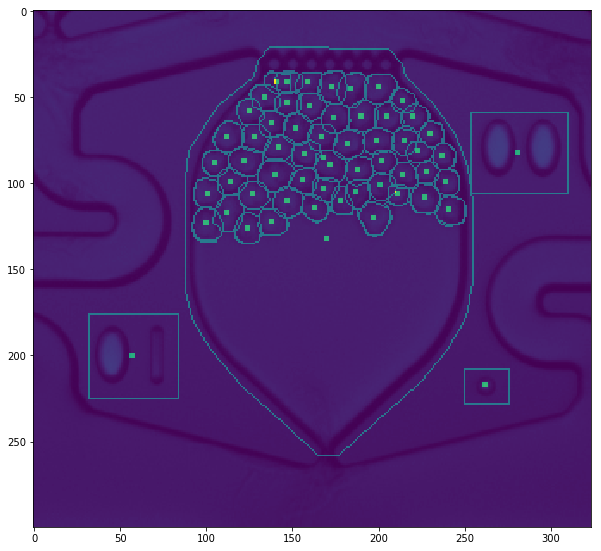

In [14]:
mask_img = reduce(lambda i1, i2: np.maximum(i1, i2), [a.border for a in img.annotations], np.zeros_like(img.image))
cent_img = reduce(lambda i1, i2: np.maximum(i1, i2), [annotation.get_centroid_mask(a, radius=2) for a in img.annotations], np.zeros_like(img.image))

a = [.3, .5, .2] 
plt.imshow(a[0] * mask_img + a[1] * cent_img + a[2]*img.image)
plt.gcf().set_size_inches(10, 12)

## Configurations

In [25]:
class CellsConfig(Config):
    """Configuration for training on cell plate datasets"""
    # Give the configuration a recognizable name
    NAME = "cells"

    # BACKBONE = "resnet101"
    BACKBONE = "resnet50"
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 2
    # IMAGES_PER_GPU = 8
    IMAGES_PER_GPU = 2 # *This is a key parameter necessary to avoid obscure CUDA errors (probably memory related)

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 6 classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Increase this to allow for large cell count predictions
    # DETECTION_MAX_INSTANCES = 100
    DETECTION_MAX_INSTANCES = 250
    
    # MAX_GT_INSTANCES = 100
    MAX_GT_INSTANCES = 250
    
config = CellsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        250
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               250
MEAN_PIXEL                     [123.7 116.8 103.9]
MIN

## Dataset

In [26]:
from skimage.color import gray2rgb

class CellsDataset(utils.Dataset):
    """Generates the cells dataset."""

    
    def load_cells(self, image_dir, indexes):
        imgs = load_images(image_dir)
        
        classes = ['StNum', 'AptNum', 'Marker', 'Chamber', 'Cell', 'CellClump']
        for i, c in enumerate(classes):
            self.add_class('cells', i+1, c)
        
        cases = []
        for i, img in enumerate(imgs):
            if img.annotations is None:
                continue
            uniq_type = np.unique([a.object_type for a in img.annotations])
            if len(np.setdiff1d(classes, uniq_type)) > 0:
                continue
            cases.append((i, img))
        
        for i in indexes:
            self.add_image('cells', image_id=cases[i][0], path=None, data=cases[i][1])

    def load_image(self, image_id):
        info = self.image_info[image_id]
        return gray2rgb(info['data'].image)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "cells":
            return info["data"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        data = info['data']
        
        # Remove any unnecessary segmentation masks
        annotations = [a for a in data.annotations if a.object_type in self.class_names]
        
        count = len(annotations)
        shape = data.image.shape
        
        # Set a single 2D mask for each annotation
        mask = np.zeros([shape[0], shape[1], count], dtype=np.uint8)
        for i, a in enumerate(annotations):
            mask[:, :, i] = a.mask
            
        # Determine class indexes for each mask
        class_ids = np.array([self.class_names.index(a.object_type) for a in annotations], dtype=np.int32)
        
        return mask.astype(np.bool), class_ids


In [27]:
# Training dataset
dataset_train = CellsDataset()
dataset_train.load_cells(DATA_DIR, list(range(22)))
dataset_train.prepare()

# # Validation dataset
dataset_val = CellsDataset()
dataset_val.load_cells(DATA_DIR, list(range(22, 30)))
dataset_val.prepare()

In [28]:
len(dataset_train.image_ids)

22

In [29]:
dataset_train.class_info

[{'id': 0, 'name': 'BG', 'source': ''},
 {'id': 1, 'name': 'StNum', 'source': 'cells'},
 {'id': 2, 'name': 'AptNum', 'source': 'cells'},
 {'id': 3, 'name': 'Marker', 'source': 'cells'},
 {'id': 4, 'name': 'Chamber', 'source': 'cells'},
 {'id': 5, 'name': 'Cell', 'source': 'cells'},
 {'id': 6, 'name': 'CellClump', 'source': 'cells'}]

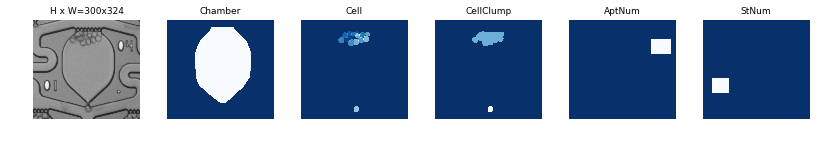

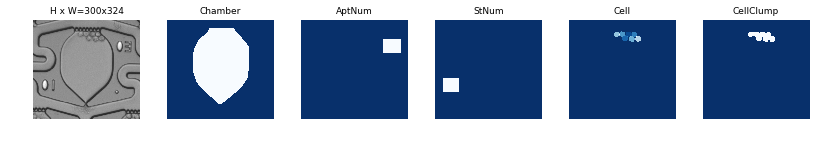

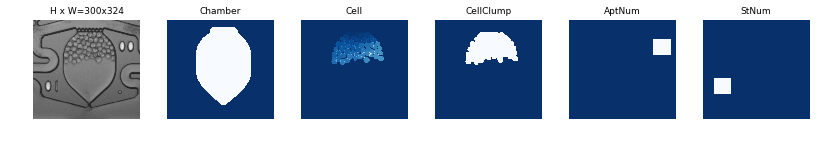

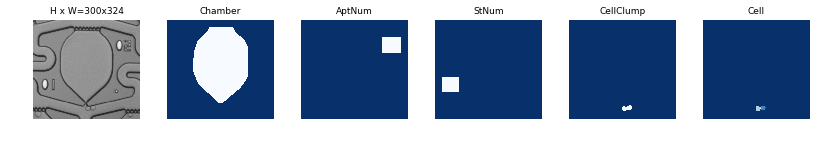

<Figure size 1152x1152 with 0 Axes>

In [30]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=5)
plt.gcf().set_size_inches(16, 16)

## Ceate Model

In [59]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [60]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last
#init_with = "imagenet"  # imagenet, coco, or last
#init_with = "last"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

In [61]:
# Ignore these warnings for now as they seem to be irrelevant
warnings.filterwarnings(
    'ignore', category=UserWarning,
    message='Converting sparse IndexedSlices to a dense Tensor of unknown shape'
)
warnings.filterwarnings(
    'ignore', category=UserWarning,
    message='Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data'
)

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=50, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /notebooks/data/model/experiments/v3/cells20180523T0536/mask_rcnn_cells_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mr

100/100 [==============================] - 36s 355ms/step - loss: 0.3901 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1623 - val_loss: 1.0159 - val_rpn_class_loss: 0.0232 - val_rpn_bbox_loss: 0.3783 - val_mrcnn_class_loss: 0.1688 - val_mrcnn_bbox_loss: 0.1890 - val_mrcnn_mask_loss: 0.2566
Epoch 20/50
100/100 [==============================] - 37s 374ms/step - loss: 0.3984 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1643 - val_loss: 1.1259 - val_rpn_class_loss: 0.0269 - val_rpn_bbox_loss: 0.4355 - val_mrcnn_class_loss: 0.1738 - val_mrcnn_bbox_loss: 0.2240 - val_mrcnn_mask_loss: 0.2656
Epoch 21/50
100/100 [==============================] - 36s 362ms/step - loss: 0.3890 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1635 - val_loss: 1.1710 - val_rpn_class_loss

Epoch 41/50
100/100 [==============================] - 36s 356ms/step - loss: 0.2273 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1218 - val_loss: 1.0119 - val_rpn_class_loss: 0.0297 - val_rpn_bbox_loss: 0.3855 - val_mrcnn_class_loss: 0.1360 - val_mrcnn_bbox_loss: 0.1740 - val_mrcnn_mask_loss: 0.2867
Epoch 42/50
100/100 [==============================] - 36s 361ms/step - loss: 0.2206 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0196 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.1162 - val_loss: 1.0217 - val_rpn_class_loss: 0.0343 - val_rpn_bbox_loss: 0.3772 - val_mrcnn_class_loss: 0.1661 - val_mrcnn_bbox_loss: 0.1568 - val_mrcnn_mask_loss: 0.2872
Epoch 43/50
100/100 [==============================] - 37s 367ms/step - loss: 0.2195 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.1208 - val_loss: 0.9490 - val_rp

In [62]:
# # Fine tune all layers
# # Passing layers="all" trains all layers. You can also 
# # pass a regular expression to select which layers to
# # train by name pattern.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=20, 
#             layers="all")

In [63]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [64]:
class InferenceConfig(CellsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [65]:
def get_model_path(checkpoint_dir, epoch):
    if checkpoint_dir is None:
        return model.find_last()[1]
    else:
        fname = 'mask_rcnn_cells_{:04d}.h5'.format(epoch)
        return osp.join(MODEL_DIR, checkpoint_dir, fname)

In [66]:
#!ls $MODEL_DIR

In [67]:

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
#model_path = get_model_path('cells20180519T2212', 50)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /notebooks/data/model/experiments/v3/cells20180523T0536/mask_rcnn_cells_0050.h5


7
original_image           shape: (384, 384, 3)         min:    0.00000  max:  209.00000  uint8
image_meta               shape: (19,)                 min:    1.00000  max:  384.00000  float64
gt_class_id              shape: (77,)                 min:    1.00000  max:    6.00000  int32
gt_bbox                  shape: (77, 4)               min:   46.00000  max:  345.00000  int32
gt_mask                  shape: (384, 384, 77)        min:    0.00000  max:    1.00000  bool


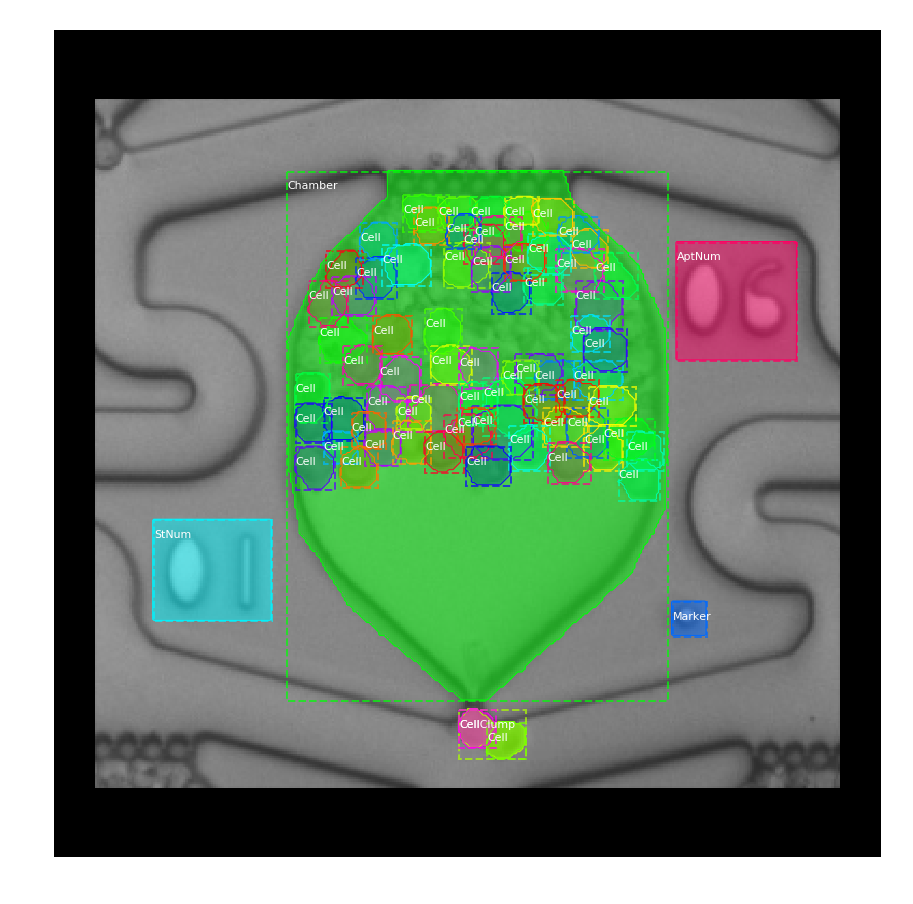

In [68]:
# Test on a random image
dataset_pred = dataset_val
#dataset_pred = dataset_train
#image_id = random.choice(dataset_pred.image_ids)
image_id = 7

print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_pred, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(16, 16))

In [69]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:  209.00000  uint8
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  105.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  384.00000  int64
anchors                  shape: (1, 36828, 4)         min:   -0.23632  max:    1.06922  float32


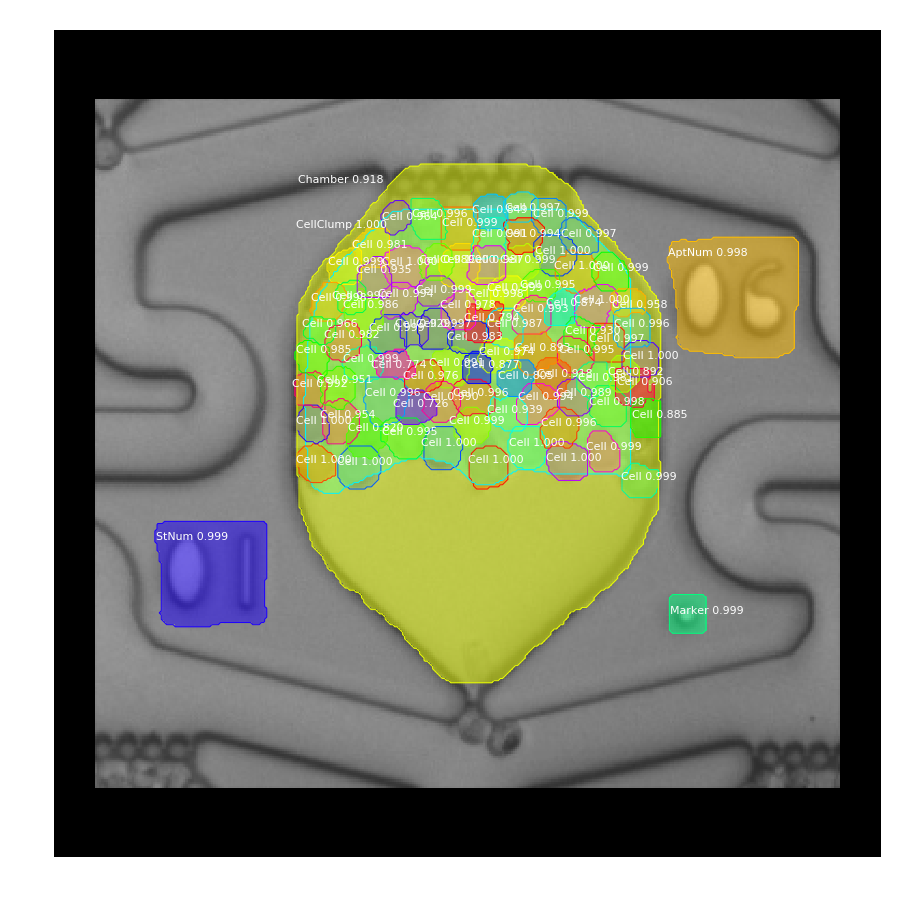

In [70]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(), show_bbox=False)

In [71]:
# dataset_val.image_reference(0).file

Saving /notebooks/data/result/experiments/v3/images/pred-evaluation-BF_ST_001_APT_005Day2.png
Saving /notebooks/data/result/experiments/v3/images/pred-evaluation-BF_ST_001_APT_005Day3.png
Saving /notebooks/data/result/experiments/v3/images/pred-evaluation-BF_ST_001_APT_005Day4.png
Saving /notebooks/data/result/experiments/v3/images/pred-evaluation-BF_ST_001_APT_006Day0.png
Saving /notebooks/data/result/experiments/v3/images/pred-evaluation-BF_ST_001_APT_006Day1.png
Saving /notebooks/data/result/experiments/v3/images/pred-evaluation-BF_ST_001_APT_006Day2.png
Saving /notebooks/data/result/experiments/v3/images/pred-evaluation-BF_ST_001_APT_006Day3.png
Saving /notebooks/data/result/experiments/v3/images/pred-evaluation-BF_ST_001_APT_006Day4.png


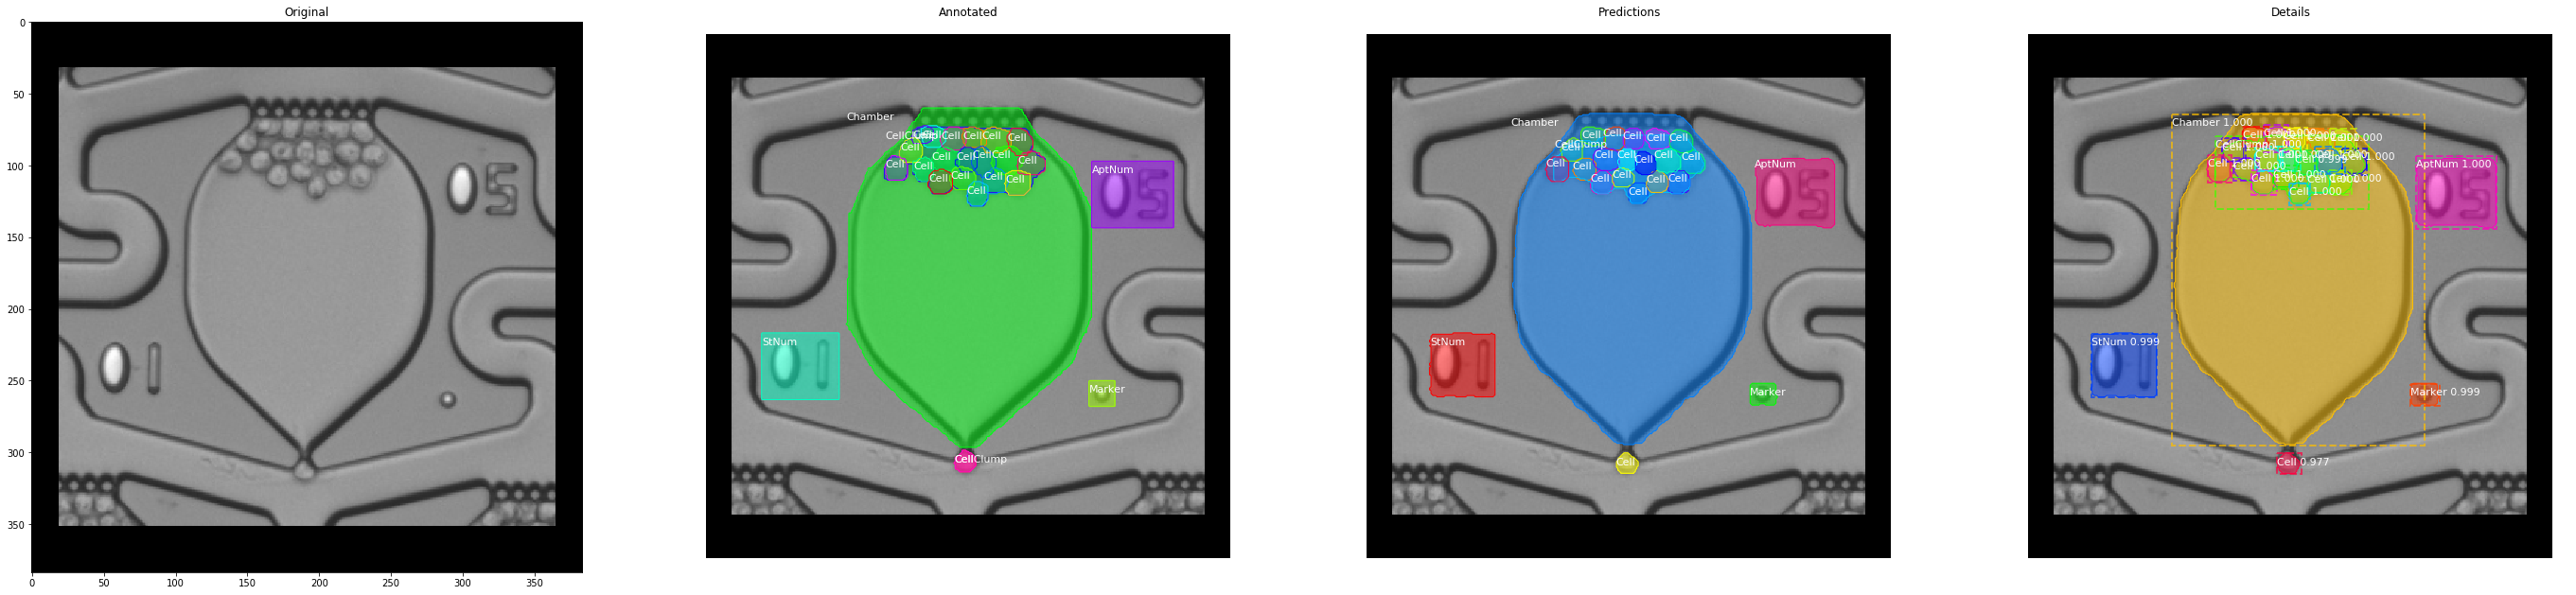

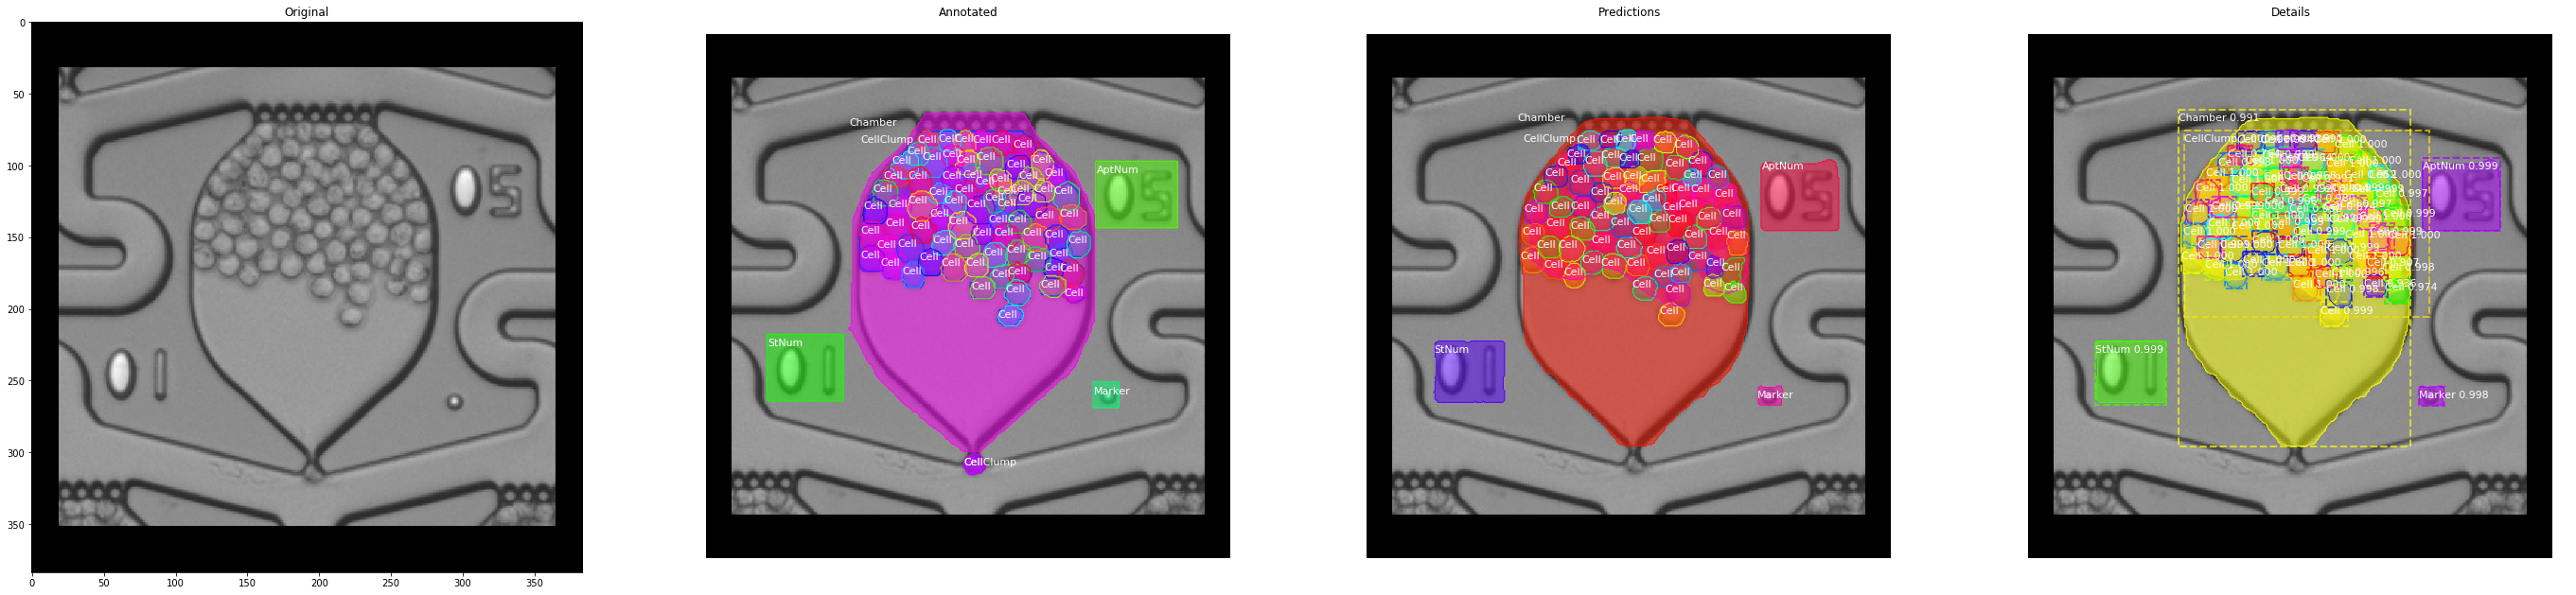

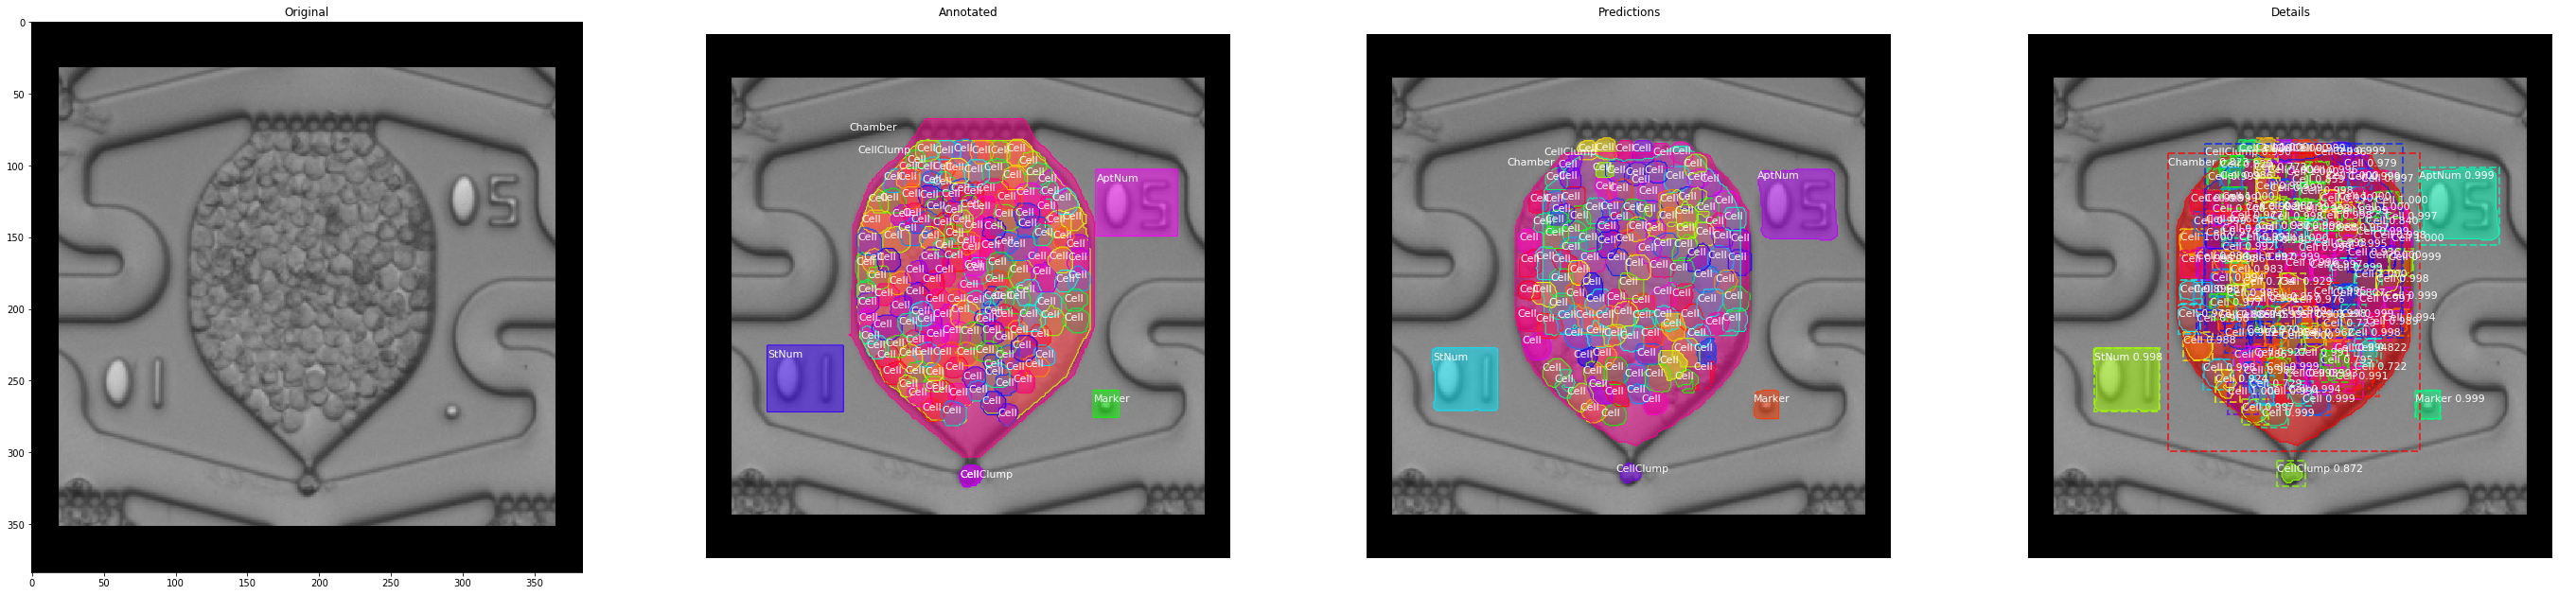

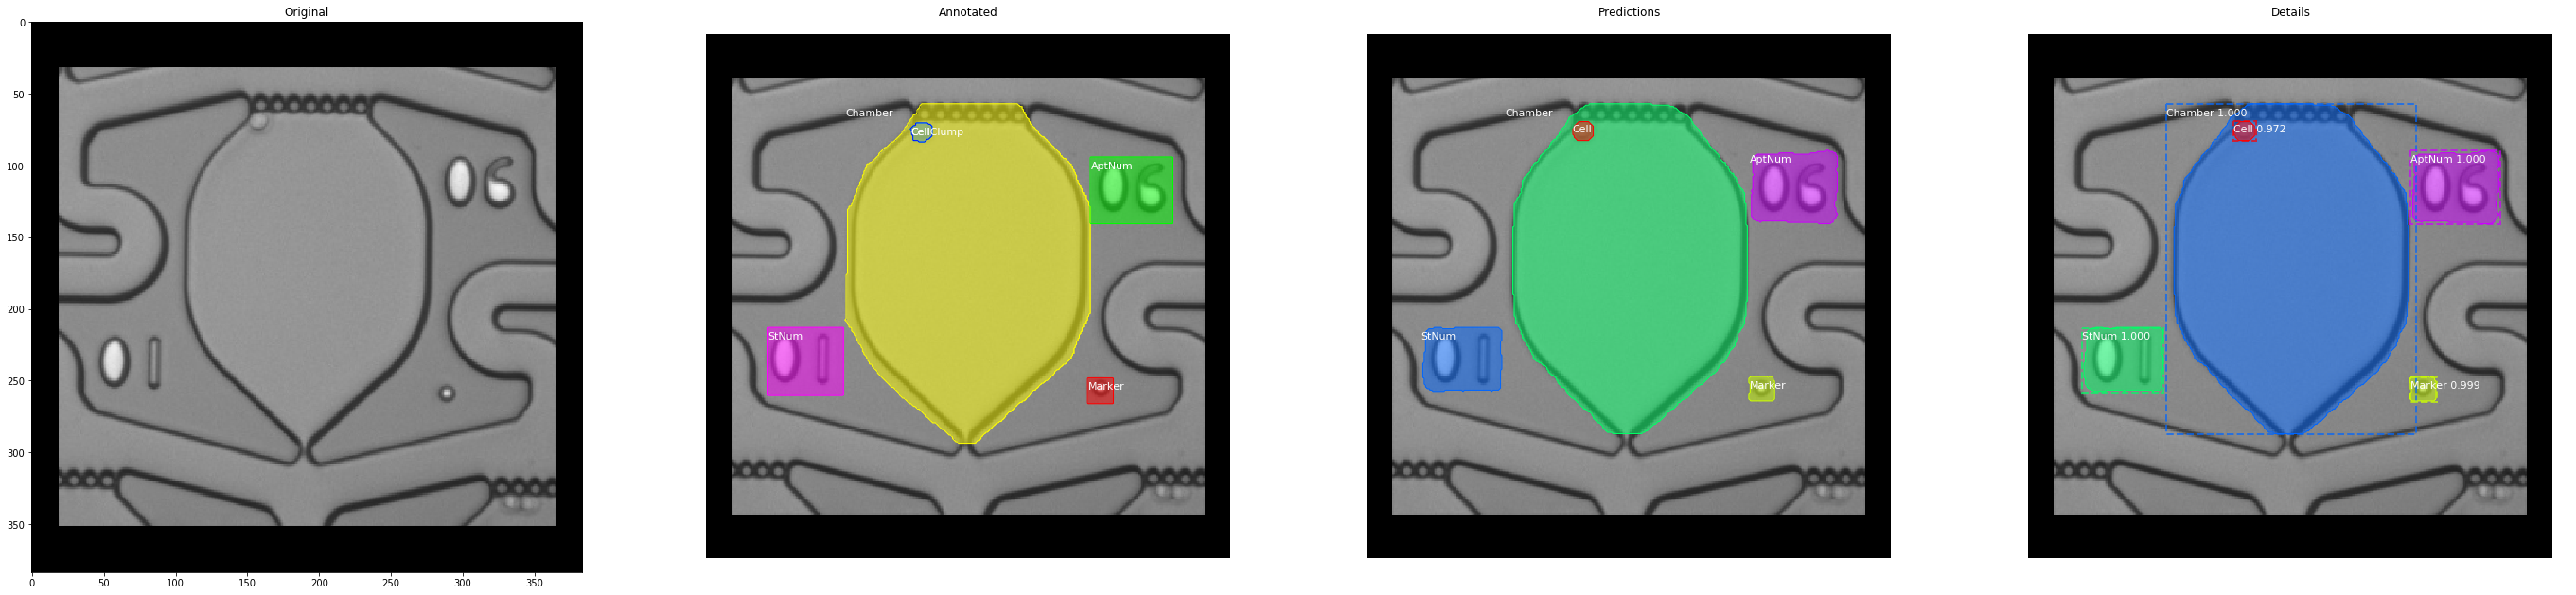

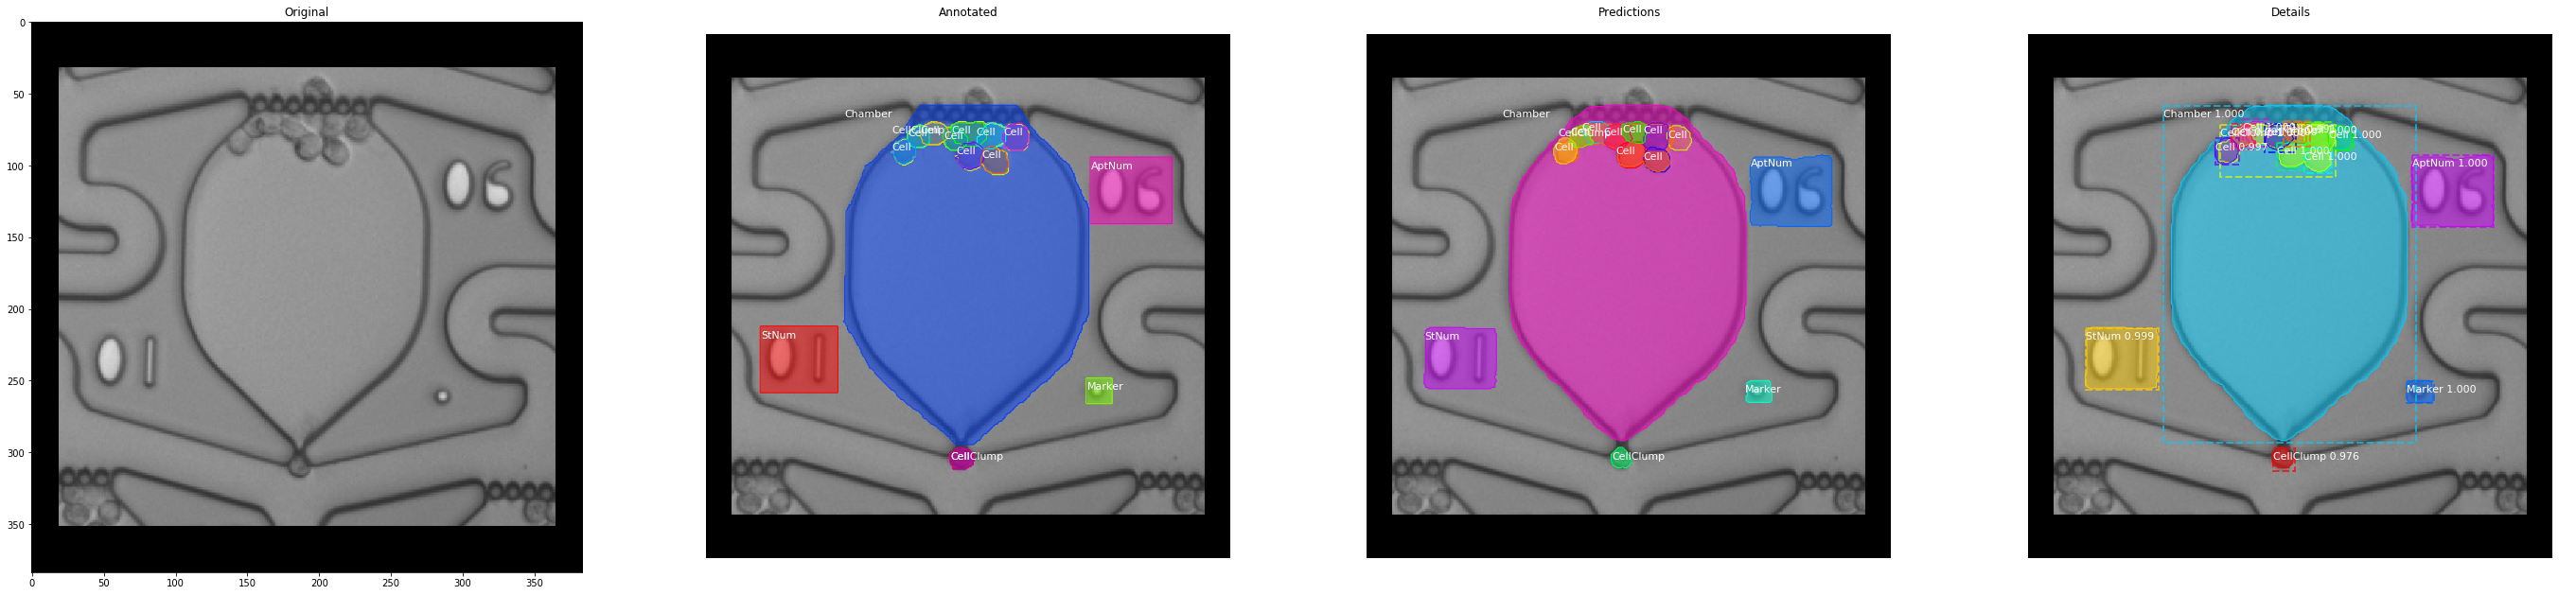

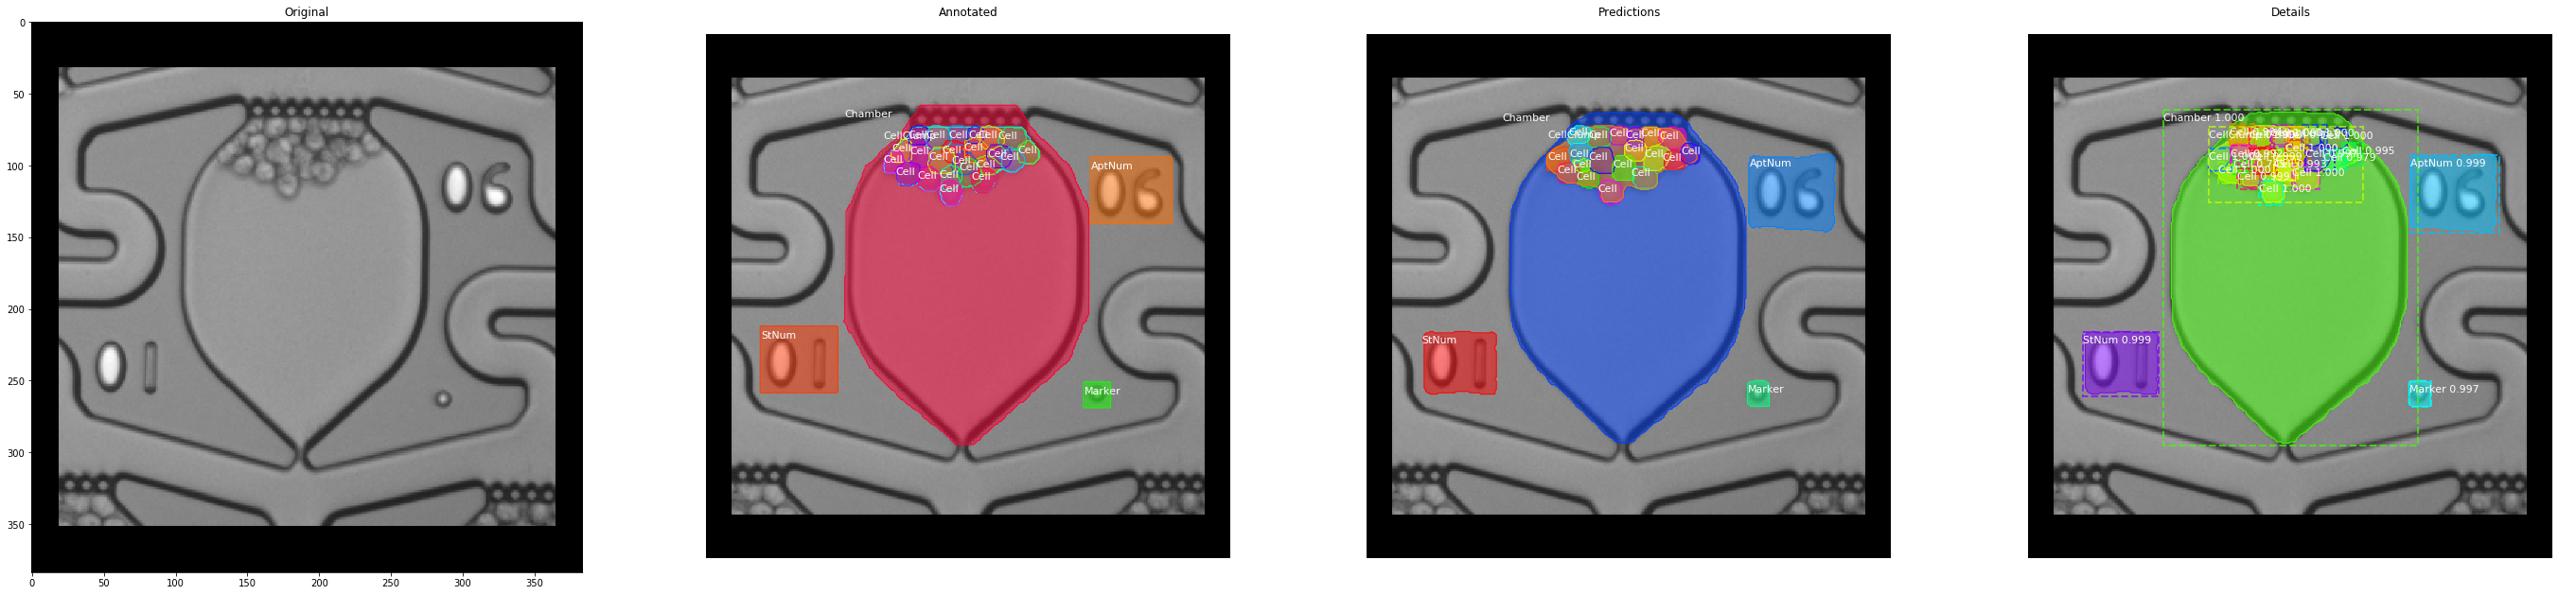

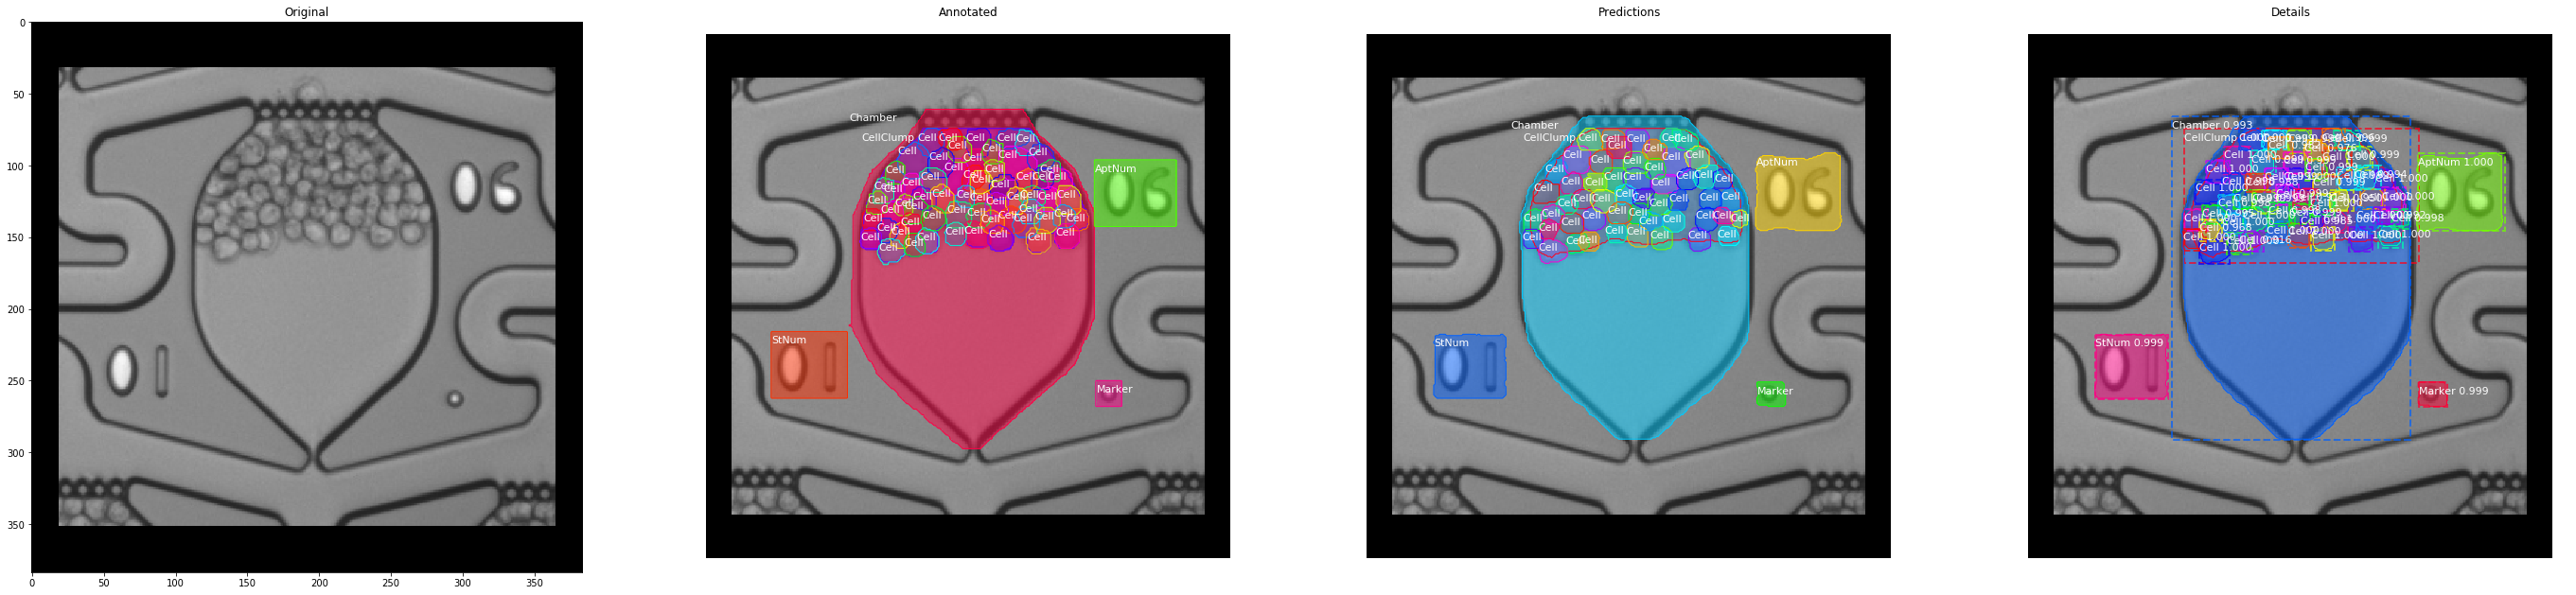

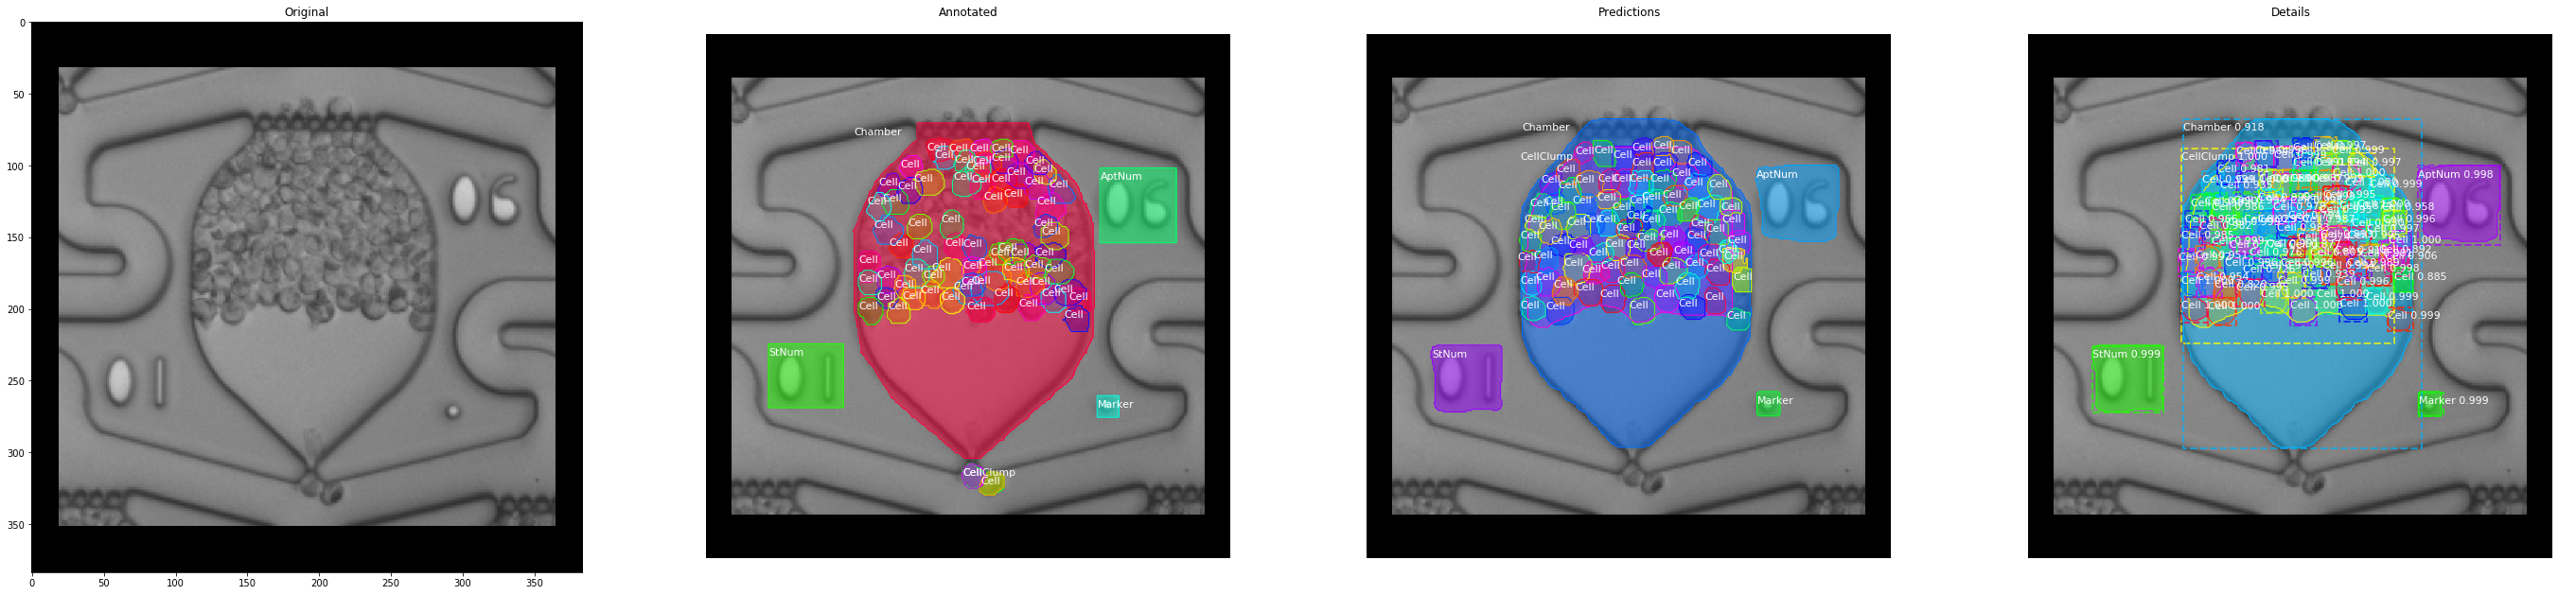

In [72]:
# dataset_pred = dataset_val
# #dataset_pred = dataset_train
# #image_id = random.choice(dataset_pred.image_ids)
# image_id = 7
# print(image_id)


def display_prediction(dataset, image_id, filepath=None):
    fig, axs = plt.subplots(1, 4, figsize=(48, 16))
    axs = axs.ravel()

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset, inference_config, image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=0)
    r = results[0]

    axs[0].imshow(original_image)
        
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, ax=axs[1], show_bbox=False)
    
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, None, ax=axs[2], show_bbox=False)
    
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=axs[3], show_bbox=True)
    
    axs[0].set_title('Original')
    axs[1].set_title('Annotated')
    axs[2].set_title('Predictions')
    axs[3].set_title('Details')
    if filepath is not None:
        print('Saving', filepath)
        fig.savefig(filepath)
        plt.ioff()
    
for image_id in dataset_val.image_ids[:10]:
    image_file = osp.basename(dataset_val.image_reference(image_id).file)
    image_file = 'pred-evaluation-' + image_file.split('.')[0] + '.png'
    path = osp.join(RESULT_DIR, 'images', image_file)
    os.makedirs(osp.dirname(path), exist_ok=True)
    display_prediction(dataset_val, image_id, path)

## Cell Counts

In [50]:
%%capture

def summarize_cell_features(dataset, class_name='Cell'):
    class_id = dataset.class_names.index(class_name)
    
    def summarize(class_ids, obj_masks):
        class_id_mask = class_ids == class_id
        # Individual cell masks as (h, w, n_cells)
        class_obj_masks = obj_masks[..., class_id_mask]
        assert class_obj_masks.ndim == 3
        count = class_id_mask.sum()
        areas = [class_obj_masks[..., i].sum() for i in range(class_obj_masks.shape[2])]
        return count, areas
        
    d = []
    for image_id in dataset.image_ids:
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config, 
                                   image_id, use_mini_mask=False)
        r = model.detect([original_image], verbose=1)[0]
        
        ct_true, ar_true = summarize(gt_class_id, gt_mask)
        ct_pred, ar_pred = summarize(r['class_ids'], r['masks'])
        d.append(dict(image_id=image_id, ct_true=ct_true, ct_pred=ct_pred, ar_true=ar_true, ar_pred=ar_pred))
    return pd.DataFrame(d)

        
d_feat = pd.concat([
    summarize_cell_features(dataset_train).assign(group='training'), 
    summarize_cell_features(dataset_val).assign(group='evaluation')
], axis=0)

In [51]:
d_feat.head()

ar_pred  \
0      [251, 218, 240, 286, 162, 235, 138, 225, 122]   
1  [290, 265, 311, 331, 262, 176, 274, 203, 291, ...   
2  [311, 285, 270, 256, 218, 274, 283, 219, 201, ...   
3                                         [145, 125]   
4                               [272, 285, 396, 304]   

                                             ar_true  ct_pred  ct_true  \
0           [176, 318, 256, 259, 258, 204, 246, 259]        9        8   
1  [315, 271, 206, 177, 295, 344, 180, 271, 281, ...       19       19   
2  [191, 185, 179, 304, 317, 200, 240, 316, 250, ...       54       55   
3                               [126, 135, 151, 284]        2        4   
4                          [208, 291, 270, 403, 330]        4        5   

   image_id     group  
0         0  training  
1         1  training  
2         2  training  
3         3  training  
4         4  training

/usr/local/lib/python3.5/dist-packages/plotnine/ggplot.py:688: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.5/dist-packages/plotnine/ggplot.py:689: UserWarning: Filename: /notebooks/data/result/experiments/v3/images/pred-counts.png
  warn('Filename: {}'.format(filename))


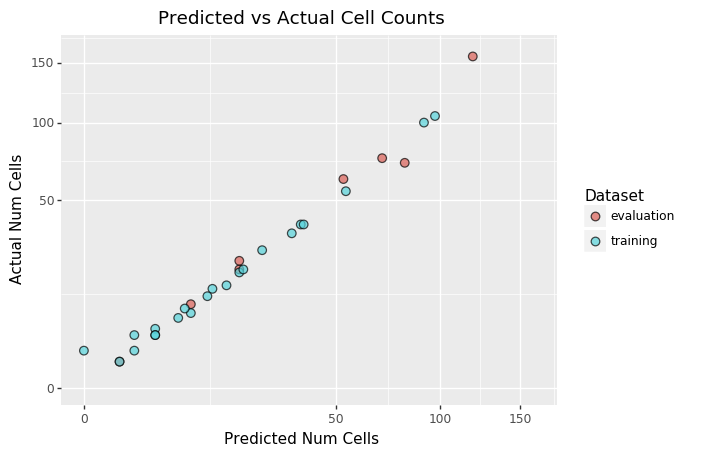

<ggplot: (-9223363293755540073)>

In [52]:
p = (
    pn.ggplot(d_feat, pn.aes(x='ct_pred', y='ct_true', fill='group')) +
    pn.geom_point(size=3, alpha=.7) + 
    pn.scale_x_sqrt(limits=(0, 160)) +
    pn.scale_y_sqrt(limits=(0, 160)) +
    pn.scale_fill_discrete(guide=pn.guide_legend(title='Dataset')) +
    pn.xlab('Predicted Num Cells') + pn.ylab('Actual Num Cells') +
    pn.ggtitle('Predicted vs Actual Cell Counts') 
)
pn.ggsave(p, osp.join(RESULT_DIR, 'images', 'pred-counts.png'))
p

In [53]:
def get_areas(d):
    return pd.DataFrame([
        (r['image_id'], r['group'], r['variable'], ar)
        for i, r in d_feat.melt(id_vars=['group', 'image_id'], value_vars=['ar_pred', 'ar_true']).iterrows()
        for ar in r['value']
    ], columns=['image_id', 'group', 'type', 'area'])

d_area = get_areas(d_feat)
d_area.head()

image_id     group     type  area
0         0  training  ar_pred   251
1         0  training  ar_pred   218
2         0  training  ar_pred   240
3         0  training  ar_pred   286
4         0  training  ar_pred   162

/usr/local/lib/python3.5/dist-packages/plotnine/ggplot.py:688: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.5/dist-packages/plotnine/ggplot.py:689: UserWarning: Filename: /notebooks/data/result/experiments/v3/images/pred-area.png
  warn('Filename: {}'.format(filename))


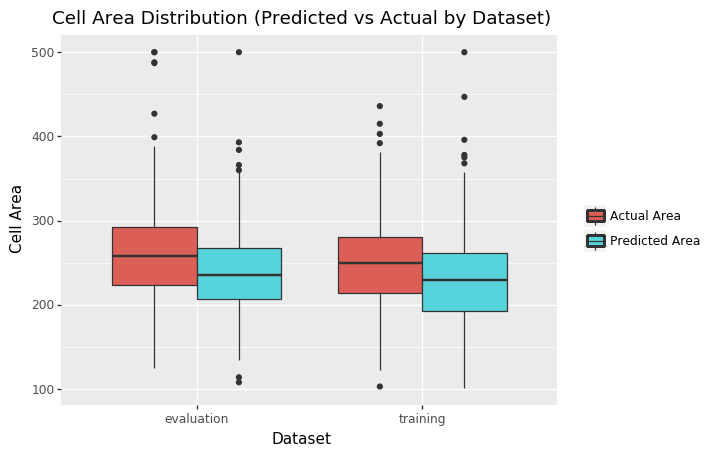

<ggplot: (-9223363293755601895)>

In [55]:
p = (
    pn.ggplot(
        d_area.assign(
            area=d_area['area'].clip_upper(500),
            type=d_area['type'].map({'ar_true': 'Actual Area', 'ar_pred': 'Predicted Area'})
        ), 
        pn.aes(x='group', y='area', fill='type')
    ) +
    pn.geom_boxplot(position='dodge') +
    pn.xlab('Dataset') + pn.ylab('Cell Area') +
    pn.scale_fill_discrete(guide=pn.guide_legend(title='')) +
    pn.ggtitle('Cell Area Distribution (Predicted vs Actual by Dataset)')
)
pn.ggsave(p, osp.join(RESULT_DIR, 'images', 'pred-area.png'))
p

In [56]:
d_area.sort_values('area').tail()

image_id       group     type  area
1690         6  evaluation  ar_true   488
462         18    training  ar_pred   505
1679         6  evaluation  ar_true   542
1775         7  evaluation  ar_true   570
783          6  evaluation  ar_pred  1504

## Evaluation

In [58]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.820772239796051
